# 성능개선 기법 실습

# 모듈 정의

## train.py
- 모델 학습과 검증 함수 정의

In [3]:
import os
os.makedirs('module', exist_ok=True)

In [4]:
%%writefile module/train.py

import torch
import time

# multi와 binary 정확도 계산이 다르다.

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset) # 전체 데이터수
    num_batches = len(dataloader)  #  step 수 
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 정확도 계산
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_batches
        test_accuracy /= size  #전체 개수로 나눈다.
    return test_loss, test_accuracy

def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_batches
        test_accuracy /= size   #전체 개수로 나눈다.
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    [parameter]
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi
    [return]
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()
    # size = len(dataloader.dataset) #총 데이터수

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if mode == 'binary':  # 이진분류이면...
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:  # 다중분류이면...
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy



def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True, save_model_path=None, early_stopping=True, patience=10, device='cpu',  mode:"binary or multi"='binary'):
    """
    모델을 학습시키는 함수

    [parameter]
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (_Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
    [return]
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
    """

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
        
    if save_best_model:
        best_score_save = torch.inf

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf
    
    # 모델 device로 옮기기
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)
        
        if mode == "binary":  # 이진분류이면...
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:  # 다중분류이면...
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 모델 저장
        if save_best_model:
            if val_loss < best_score_save:  # 성능개선
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es:  # 성능개선
                best_score_es = val_loss  
                trigger_count = 0
                                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    break
                    
        # save_best_model과 early_stopping이 둘 다 True일 경우, 맨 위에 있는 save_best_model가 먼저 실행되기에...
        # best_score_save와 best_score_es 따로 분리해서 val_loss값을 저장한다.
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Writing module/train.py


## data.py
- dataset 생성 함수 제공 모듈

In [5]:
%%writefile module/data.py
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(root_path, batch_size, is_train=True):
    """
    mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader 
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.MNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

def load_fashion_mnist_dataset(root_path, batch_size, is_train=True):
    """
    fashion mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

Writing module/data.py


In [27]:
# %%writefile module/utils.py
# import matplotlib.pyplot as plt

def plot_fit_result(train_loss_list,train_acc_list, val_loss_list, val_acc_list):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title('Loss')
    plt.plot(train_loss_list,label='Train')
    plt.plot(val_loss_list,label='Validation')
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy')
    plt.plot(train_acc_list,label='Train')
    plt.plot(val_acc_list,label='Validation')
    plt.legend()

    plt.tight_layout()
    plt.show()

## 하이퍼파라미터, 변수 정의

In [4]:
# import

import torch
import torch.nn as nn
from torchinfo import summary

from module.train import fit
from module import data

import os
import matplotlib.pyplot as plt

In [1]:
# Data 저장할 디렉토리 경로
DATASET_ROOT_PATH='datasets'
MODEL_SAVE_ROOT_PATH='models'

N_EPOCH=10
BATCH_SIZE=256
LR=0.001

# Data 준비

## mnist 데이터 로딩

In [7]:
train_loader = data.load_mnist_dataset(DATASET_ROOT_PATH,BATCH_SIZE,True)
test_loader = data.load_mnist_dataset(DATASET_ROOT_PATH,BATCH_SIZE,False)

In [11]:
print(train_loader)
print("steps num : ", len(train_loader))
print("data의 shape : ", train_loader.dataset.data.shape)
print(train_loader.dataset)

steps num :  235
data의 shape :  torch.Size([60000, 28, 28])
Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


# 모델의 크기 변경에 따른 성능변화

In [29]:
class SizeCheckModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input -> output
        self.output = nn.Linear(28*28,10) 
        # in : mnist 이미지 크기(28*28) , out : class개수 (0~9: 10)
        
    def forward(self,X):
        out = nn.Flatten()(X)
        out = self.output(out)
        
        return out
    

In [30]:
model = SizeCheckModel()
summary(model,(256,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
SizeCheckModel                           [256, 10]                 --
├─Linear: 1-1                            [256, 10]                 7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 2.01
Input size (MB): 0.80
Forward/backward pass size (MB): 0.02
Params size (MB): 0.03
Estimated Total Size (MB): 0.85

In [31]:
device='cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'  ## 그냥 cpu로 해도 된다.

In [32]:
# 학습
model =model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=LR)
loss_fn = nn.CrossEntropyLoss()

train_loss_list,train_acc_list,val_loss_list, val_acc_list=\
fit(train_loader,test_loader, model, loss_fn,optimizer,N_EPOCH,
    save_best_model=False, early_stopping=False, device=device, mode='multi')


Epoch[1/10] - Train loss: 0.48472 Train Accucracy: 0.88238 || Validation Loss: 0.46164 Validation Accuracy: 0.88870
Epoch[2/10] - Train loss: 0.37898 Train Accucracy: 0.90088 || Validation Loss: 0.35940 Validation Accuracy: 0.90620
Epoch[3/10] - Train loss: 0.33876 Train Accucracy: 0.90860 || Validation Loss: 0.32295 Validation Accuracy: 0.91220
Epoch[4/10] - Train loss: 0.31668 Train Accucracy: 0.91353 || Validation Loss: 0.30344 Validation Accuracy: 0.91520
Epoch[5/10] - Train loss: 0.30371 Train Accucracy: 0.91595 || Validation Loss: 0.29317 Validation Accuracy: 0.91770
Epoch[6/10] - Train loss: 0.29298 Train Accucracy: 0.91960 || Validation Loss: 0.28431 Validation Accuracy: 0.91890
Epoch[7/10] - Train loss: 0.28512 Train Accucracy: 0.92087 || Validation Loss: 0.27723 Validation Accuracy: 0.92180
Epoch[8/10] - Train loss: 0.27938 Train Accucracy: 0.92197 || Validation Loss: 0.27483 Validation Accuracy: 0.92270
Epoch[9/10] - Train loss: 0.27599 Train Accucracy: 0.92325 || Validation

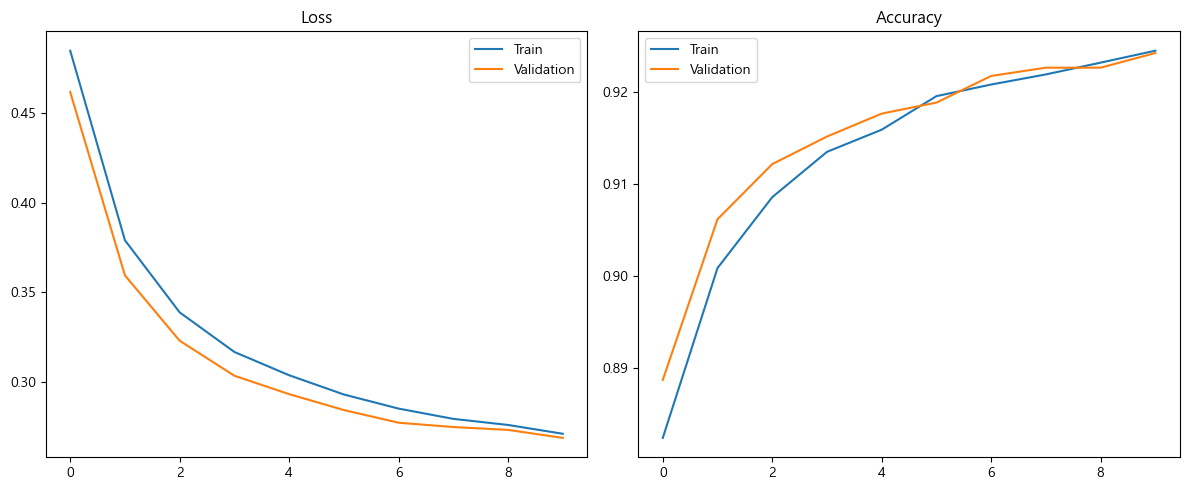

In [38]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(train_loss_list,label='Train')
plt.plot(val_loss_list,label='Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(train_acc_list,label='Train')
plt.plot(val_acc_list,label='Validation')
plt.legend()

plt.tight_layout()
plt.show()

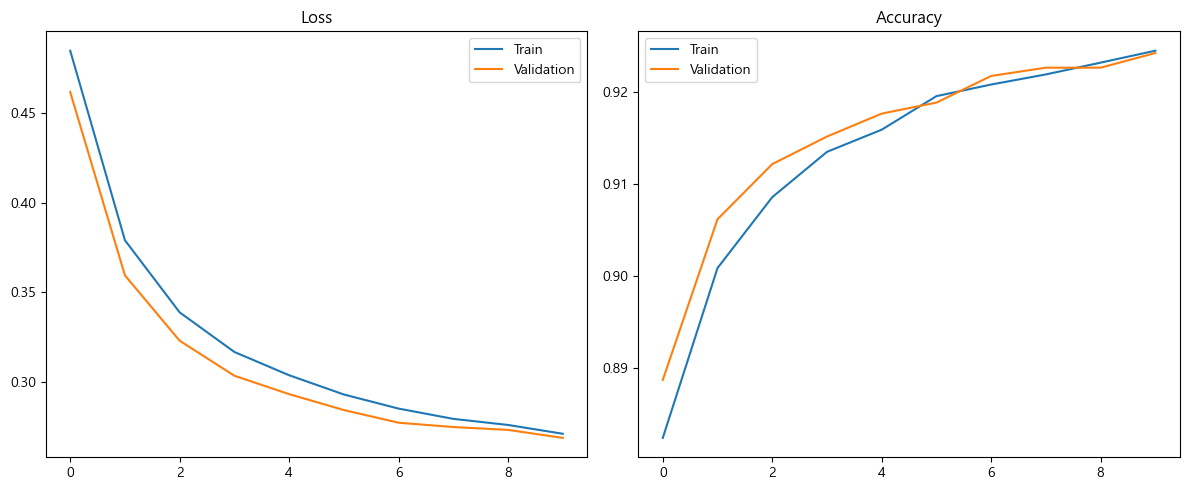

In [39]:
# from module.utils import plot_fit_result
plot_fit_result(train_loss_list, train_acc_list,val_loss_list, val_acc_list)

In [33]:
# Layer block 정의, 단순 순차구조의 모델을 정의할때도 사용
# 가변인자 형식으로 넣어준다.
b1 = nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU()
        )

o=b1(X)

# Sequential 이 아래처럼 순차적으로 처리해서 결과를 반환
# t=nn.Linear(64,32)(X)
# o=nn.ReLU()(t)

Sequential()

In [34]:

class SizeCheckModel_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1=nn.Sequential(nn.Linear(28*28,2048),nn.ReLU())
        self.block2=nn.Sequential(nn.Linear(2048,1024),nn.ReLU())
        self.block3=nn.Sequential(nn.Linear(1024,512),nn.ReLU())
        self.block4=nn.Sequential(nn.Linear(512,256),nn.ReLU())
        self.block5=nn.Sequential(nn.Linear(256,128),nn.ReLU())
        self.block6=nn.Sequential(nn.Linear(128,64),nn.ReLU())
        
        self.output = nn.Linear(64,10)
        
    def forward(self,X):  # 입력 ( batch, 1, 28,28)
        out = nn.Flatten()(X) # (batch, 1* 28*28)
        out=self.block1(out)
        out=self.block2(out)
        out=self.block3(out)
        out=self.block4(out)
        out=self.block5(out)
        out=self.block6(out)
        out = self.output(out)
        
        return out
    

In [35]:
big_model=SizeCheckModel_2().to(device)
summary(big_model, (BATCH_SIZE,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
SizeCheckModel_2                         [256, 10]                 --
├─Sequential: 1-1                        [256, 2048]               --
│    └─Linear: 2-1                       [256, 2048]               1,607,680
│    └─ReLU: 2-2                         [256, 2048]               --
├─Sequential: 1-2                        [256, 1024]               --
│    └─Linear: 2-3                       [256, 1024]               2,098,176
│    └─ReLU: 2-4                         [256, 1024]               --
├─Sequential: 1-3                        [256, 512]                --
│    └─Linear: 2-5                       [256, 512]                524,800
│    └─ReLU: 2-6                         [256, 512]                --
├─Sequential: 1-4                        [256, 256]                --
│    └─Linear: 2-7                       [256, 256]                131,328
│    └─ReLU: 2-8                         [256, 256]          

In [36]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(big_model.parameters(),lr=LR)

result=fit(train_loader,test_loader,big_model,loss_fn,optimizer,N_EPOCH,
          save_best_model=False, early_stopping=False,device=device,mode='multi')

Epoch[1/10] - Train loss: 0.12880 Train Accucracy: 0.96223 || Validation Loss: 0.13288 Validation Accuracy: 0.95870
Epoch[2/10] - Train loss: 0.08302 Train Accucracy: 0.97542 || Validation Loss: 0.10372 Validation Accuracy: 0.96890
Epoch[3/10] - Train loss: 0.06020 Train Accucracy: 0.98237 || Validation Loss: 0.09148 Validation Accuracy: 0.97260
Epoch[4/10] - Train loss: 0.04935 Train Accucracy: 0.98493 || Validation Loss: 0.09190 Validation Accuracy: 0.97270
Epoch[5/10] - Train loss: 0.02270 Train Accucracy: 0.99313 || Validation Loss: 0.06994 Validation Accuracy: 0.98070
Epoch[6/10] - Train loss: 0.02046 Train Accucracy: 0.99397 || Validation Loss: 0.07663 Validation Accuracy: 0.97910
Epoch[7/10] - Train loss: 0.04217 Train Accucracy: 0.98828 || Validation Loss: 0.09423 Validation Accuracy: 0.97640
Epoch[8/10] - Train loss: 0.02502 Train Accucracy: 0.99217 || Validation Loss: 0.09020 Validation Accuracy: 0.97670
Epoch[9/10] - Train loss: 0.01665 Train Accucracy: 0.99510 || Validation

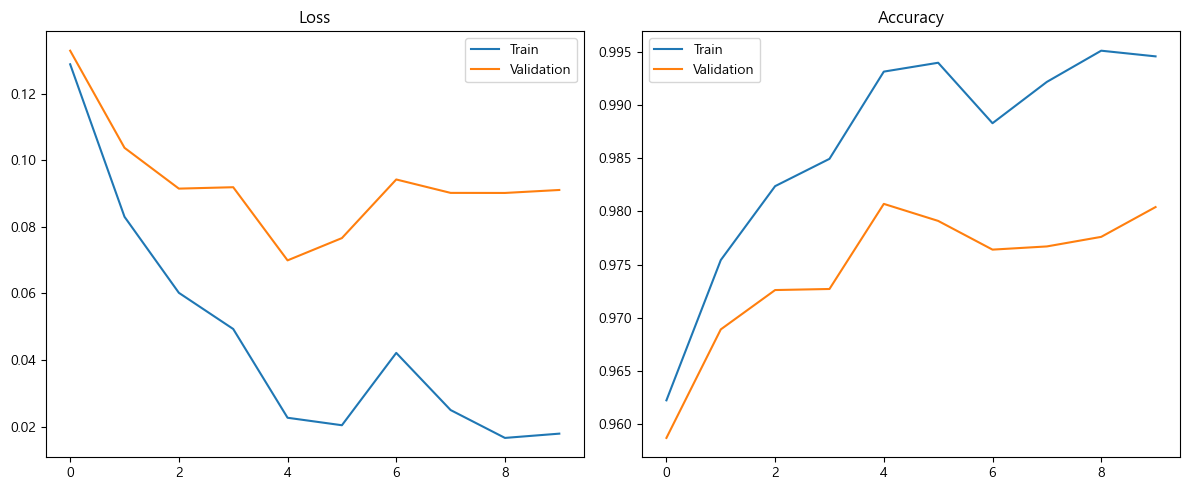

In [37]:
plot_fit_result(*result)

# Dropout 예제
- dropout 각 레이어에 적용
    - dropout은 layers.Dropout 객체를 사용
    - 객체 생성시 dropout_rate 설정: 0.2 ~ 0.5
    - Drop시킬 노드를 가진 Layer 뒤에 추가한다.

In [5]:
x=torch.randn(5,3)
print(x.shape)
x

torch.Size([5, 3])


tensor([[-0.7596, -0.6260, -0.5316],
        [-2.4679, -0.4878, -1.3505],
        [ 0.1461, -1.6157,  1.8653],
        [-0.4220,  1.8106,  0.5112],
        [ 0.1574, -0.9638,  0.0052]])

In [6]:
ln_layer=nn.Linear(3,4)
y=ln_layer(x)

In [7]:
y

tensor([[-0.2665, -0.6037, -1.0668, -0.8183],
        [-0.4359, -1.3859, -1.5397, -1.8992],
        [-0.5663,  0.0080, -0.4934,  1.0610],
        [-0.7710,  1.2130,  0.5080, -0.5905],
        [-0.1674, -0.2933, -0.8984, -0.1299]], grad_fn=<AddmmBackward0>)

In [8]:
do_layer=nn.Dropout(0.5)
z=do_layer(y)

In [9]:
print(z.shape)

torch.Size([5, 4])


In [10]:
print(z)

tensor([[-0.5331, -0.0000, -2.1337, -1.6366],
        [-0.0000, -2.7719, -0.0000, -0.0000],
        [-0.0000,  0.0161, -0.9868,  2.1221],
        [-1.5419,  0.0000,  0.0000, -0.0000],
        [-0.3347, -0.5867, -0.0000, -0.2598]], grad_fn=<MulBackward0>)


# Batch Normalization
- Dense => BN => Activation

In [2]:
class DropoutModel(nn.Module):
#     nn.Dropout(p=0.3)(nn.ReLU()(nn.Linear()(out)))
    def __init__(self):
        super().__init__()
        self.block1=nn.Sequential(nn.Linear(28*28,2048),nn.ReLU())
        self.block2=nn.Sequential(nn.Linear(2048,1024),nn.ReLU())
        self.block3=nn.Sequential(nn.Linear(1024,512),nn.ReLU())
        self.block4=nn.Sequential(nn.Linear(512,256),nn.ReLU())
        self.block5=nn.Sequential(nn.Linear(256,128),nn.ReLU())
        self.block6=nn.Sequential(nn.Linear(128,64),nn.ReLU())
        
        self.output = nn.Linear(64,10)
        
    def forward(self,X):  # 입력 ( batch, 1, 28,28)
        out = nn.Flatten()(X) # (batch, 1* 28*28)
        out=self.block1(out)
        out=self.block2(out)
        out=self.block3(out)
        out=self.block4(out)
        out=self.block5(out)
        out=self.block6(out)
        out = self.output(out)
        out = nn.Dropout(p=0.5)(out) # 마지막 출력 layer에 dropout적용
        
        return out

NameError: name 'nn' is not defined

In [1]:
d_model=DropoutModel().to(device)
summary(d_model,(BATCH_SIZE,1,28,28))

NameError: name 'DropoutModel' is not defined

# Learning rate decay

### Optimizer와 Learning rate scheduler의 속성, 메소드 확인
- 파이토치는 `torch.optim` 모듈에서 다양한 Learning rate 알고리즘을 제공한다.

#### StepLR

#### CosineAnnealingLR
cosine 그래프를 그리면서 learning rate를 변경 하는 방식.  
최근에는 learning rate를 단순히 감소시키기 보다는 감소와 증가를 반복하여 진동하는 방식으로 최적점을 찾아가는 알고리즘을 많이 사용한다. 이러한 방법 중 가장 간단하면서도 많이 사용되는 방법이 CosineAnnealingLR이다.

#### CosineAnnealingWarmRestarts

cosine annealing의 스케쥴링에 cosine 주기의 에폭을 점점 늘리거나 줄일 수 있다. (보통 늘린다.)